In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Conv2DTranspose, Flatten, Dense, Reshape, Lambda, add, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.image import psnr
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import random

In [3]:
(train_img, _), (test_img, _) = cifar100.load_data()

train_img = train_img.astype('float32') / 255.0
test_img = test_img.astype('float32') / 255.0

val_img = train_img[50000:]
train_img = train_img[:50000]

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


# All autoencoders

### Deep Convolutional AE

In [4]:
inp = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inp)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
out = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

model1 = Model(inp, out)

In [5]:
model1.load_weights('/kaggle/input/vanilla/keras/default/1/vanilla_ae.h5')

In [ ]:
model1.compile(optimizer='adam', loss=MeanSquaredError())

In [ ]:
model1.summary()

### Sparse AE

In [6]:
def kldiv(activation):
    
    mean = K.mean(activation, axis=0)
    kl = K.sum(p * K.log(p / (mean + K.epsilon())) + (1 - p) * K.log((1 - p) / (1 - mean + K.epsilon())))
    return kl

In [7]:
inp = Input(shape=(32,32,3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inp)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

bottleneck = Flatten()(encoded)  
bottleneck = Dense(64, activation='relu')(bottleneck)  
bottleneck = Dense(64, activation='sigmoid', name='bottleneck')(bottleneck)

x = Dense(4096, activation='relu')(bottleneck)  
x = Reshape((8, 8, 64))(x)  
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
out = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

model2 = Model(inp, out)

In [8]:
model2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │       266,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 64)       │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 608,259 (2.32 MB)

 Trainable params: 608,259 (2.32 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
weight = 0.1

def loss(y_true, y_pred):
    mse = MeanSquaredError()
    init_loss = mse(y_true, y_pred)
    s_model = Model(model2.input, model2.get_layer('bottleneck').output)
    s_out = s_model(y_pred)
    sparsity_loss = kldiv(s_out) 
    return init_loss + weight * sparsity_loss

In [10]:
model2.compile(optimizer='adam', loss=loss)

In [ ]:
model2.load_weights('/kaggle/input/sparse/keras/default/1/sparse_ae.h5')

### Denoising AE

In [11]:
inp = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inp)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
out = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

model3 = Model(inp, out)

In [ ]:
model3.compile(optimizer='adam', loss=MeanSquaredError())

In [12]:
model3.load_weights('/kaggle/input/denoising/keras/default/1/denoising_ae.h5')

### Variational AE

In [13]:
latent_dim = 64

In [14]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var)*epsilon

In [15]:
inp = Input(shape=(32,32,3))
x = Conv2D(32, (3,3), activation='relu', padding='same')(inp)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten()(encoded)

z_mean = Dense(latent_dim)(encoded)
z_log_var = Dense(latent_dim)(encoded)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

dec_inp = Input(shape=(latent_dim,))
x = Dense(4096, activation='relu')(dec_inp)
x = Reshape((8, 8, 64))(x)  
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
out = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

In [16]:
encoder = Model(inp, [z_mean, z_log_var, z])
decoder = Model(dec_inp, out)
dec_out = decoder(encoder(inp)[2])
model4 = Model(inp, dec_out)

In [ ]:
model4.summary()

In [ ]:
model4.compile(optimizer='adam', loss=MeanSquaredError())

In [17]:
model4.load_weights('/kaggle/input/variational/keras/default/1/variational_ae.h5')

### Residual AE

In [18]:
inp = Input(shape=(32,32,3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inp)
res = Conv2D(32, (3, 3), padding='same')(x)
x = add([x, res])
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
res = Conv2D(64, (3, 3), padding='same')(x)
x = add([x, res])
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
res = Conv2D(64, (3, 3), padding='same')(x)
x = add([x, res])
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
out = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

model5 = Model(inp, out)

In [ ]:
model5.summary()

In [ ]:
model5.compile(optimizer='adam', loss=MeanSquaredError())

In [19]:
model5.load_weights('/kaggle/input/residual_ae/keras/default/1/residual_ae.h5')

### Skip-Connected AE

In [20]:
inp = Input(shape=(32,32,3))

x = Conv2D(64, (3, 3), activation='relu', padding='same')(inp)
x = MaxPooling2D((2, 2), padding='same')(x)
skip_1 = x  
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
skip_2 = x 
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Concatenate()([x, skip_2]) 
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Concatenate()([x, skip_1]) 
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
out = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

model6 = Model(inp, out)

In [ ]:
model6.compile(optimizer='adam', loss=MeanSquaredError())

In [ ]:
model6.summary()

In [21]:
model6.load_weights('/kaggle/input/skip-connected-ae/keras/default/1/skip_connected.h5')

# Training

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### Vanilla AE

In [ ]:
model5.fit(train_img, train_img, epochs=50, batch_size=32, validation_data=(test_img, test_img), callbacks=[early_stopping])

In [ ]:
pred_img = model1.predict(test_img)

In [ ]:
num = 10

plt.figure(figsize=(10, 4))
for i in range(10):
    ax = plt.subplot(2, num, i + 1)
    plt.imshow(test_img[i])
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, num, i + 1 + num)
    plt.imshow(pred_img[i])

In [ ]:
model5.save('/kaggle/working/residual_ae.h5')

### Sparse AE

In [ ]:
model2.fit(train_img, train_img, epochs=50, batch_size=32, validation_data=(test_img, test_img), callbacks=[early_stopping])

In [ ]:
pred_img = model2.predict(test_img)

In [ ]:
num = 10

plt.figure(figsize=(10, 4))
for i in range(10):
    ax = plt.subplot(2, num, i + 1)
    plt.imshow(test_img[i])
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, num, i + 1 + num)
    plt.imshow(pred_img[i])
    plt.title("New")
    plt.axis('off')

plt.suptitle("Sparse AE")
plt.tight_layout()
plt.show()

In [ ]:
model2.save('/kaggle/working/sparse_ae.h5')

### Denoising AE

In [ ]:
noise = 0.5 

train_noisy = train_img + noise * np.random.normal(loc=0.0, scale=1.0, size=train_img.shape)
train_noisy = np.clip(train_noisy, 0., 1.)

test_noisy = test_img + noise * np.random.normal(loc=0.0, scale=1.0, size=test_img.shape)
test_noisy = np.clip(test_noisy, 0., 1.)

In [ ]:
model3.fit(train_noisy, train_img, epochs=50, batch_size=32, validation_data=(test_noisy, test_img), callbacks=[early_stopping])

In [ ]:
pred_img = model3.predict(test_img)

In [ ]:
num = 10

plt.figure(figsize=(10, 4))
for i in range(10):
    ax = plt.subplot(2, num, i + 1)
    plt.imshow(test_img[i])
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, num, i + 1 + num)
    plt.imshow(pred_img[i])
    plt.title("New")
    plt.axis('off')

plt.suptitle("Denoising AE")
plt.tight_layout()
plt.show()

In [ ]:
model3.save('/kaggle/working/denoising_ae.h5')

### Variational AE

In [ ]:
model4.fit(train_img, train_img, epochs=50, batch_size=32, validation_data=(test_img, test_img), callbacks=[early_stopping])

In [ ]:
pred_img = model4.predict(test_img)

In [ ]:
num = 10

plt.figure(figsize=(10, 4))
for i in range(10):
    ax = plt.subplot(2, num, i + 1)
    plt.imshow(test_img[i])
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, num, i + 1 + num)
    plt.imshow(pred_img[i])
    plt.title("New")
    plt.axis('off')

plt.suptitle("Variational AE")
plt.tight_layout()
plt.show()

In [ ]:
model4.save('/kaggle/working/variational_ae.h5')

### Residual AE

In [ ]:
model5.fit(train_img, train_img, epochs=50, batch_size=32, validation_data=(test_img, test_img), callbacks=[early_stopping])

In [ ]:
pred_img = model5.predict(test_img)

In [ ]:
num = 10

plt.figure(figsize=(10, 4))
for i in range(10):
    ax = plt.subplot(2, num, i + 1)
    plt.imshow(test_img[i])
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, num, i + 1 + num)
    plt.imshow(pred_img[i])
    plt.title("New")
    plt.axis('off')

plt.suptitle("Residual AE")
plt.tight_layout()
plt.show()

In [ ]:
model5.save('/kaggle/working/residual_ae.h5')

 ### Skip-connected AE

In [ ]:
model6.fit(train_img, train_img, epochs=50, batch_size=32, validation_data=(test_img, test_img), callbacks=[early_stopping])

In [ ]:
pred_img = model6.predict(test_img)

In [ ]:
num = 10

plt.figure(figsize=(10, 4))
for i in range(10):
    ax = plt.subplot(2, num, i + 1)
    plt.imshow(test_img[i])
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, num, i + 1 + num)
    plt.imshow(pred_img[i])
    plt.title("New")
    plt.axis('off')

plt.suptitle("Skip Connected AE")
plt.tight_layout()
plt.show()

In [ ]:
model6.save('/kaggle/working/skip_connected.h5')

# Ensemble

In [22]:
models = [model1, model2, model3, model4, model5, model6]

### Metrics

In [ ]:
def check(image, og_size, models):
    p = []
    s = []
    c = []
    for model in models:
        test_img = model.predict(np.expand_dims(image, axis=0))[0]
        ssim_score = ssim(image, test_img, multichannel=True, win_size=3, data_range=1.0)
        
        img1 = tf.convert_to_tensor(image, dtype=tf.float32)
        test_img1 = tf.convert_to_tensor(test_img, dtype=tf.float32)
        psnr_score = psnr(img1, test_img1, max_val=1)
        psnr_score = psnr_score.numpy()

        file = 'test_img.png'
        plt.imsave(file, test_img)
        size = os.path.getsize(file)
        compression_score = og_size/size

        p.append(psnr_score)
        s.append(ssim_score)
        c.append(compression_score)

    return p, s, c

In [ ]:
np.save('/kaggle/working/cmp',cmp)

In [ ]:
for idx, image in enumerate(test_img[5000:]):
    file = 'og_img.png'
    plt.imsave(file, image)
    og_size = os.path.getsize(file)
    p, s, c = check(image, og_size, models)
    ss.append(s)
    ps.append(p)
    cmp.append(c)
    if (idx+1)%100==0:
        print(f"{idx+1} done")

In [23]:
cmp = np.load('/kaggle/input/arrays/cmp.npy')
ps = np.load('/kaggle/input/arrays/ps.npy')
ss = np.load('/kaggle/input/arrays/ss.npy')

In [24]:
model_names = ['Convolutional', 'Sparse', 'Denoising', 'Variational', 'Residual', 'Skip-Connected']

In [ ]:
x_values = np.arange(1, 10001)  # Image indices from 1 to 10000

# Plot PSNR scores for all models
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.plot(x_values, ps[:, i], label=model_names[i])
plt.xlabel("Image Index")
plt.ylabel("PSNR Score")
plt.title("PSNR Scores for Each Model Across Images")
plt.legend()
plt.show()

# Plot SSIM scores for all models
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.plot(x_values, ss[:, i], label=model_names[i])
plt.xlabel("Image Index")
plt.ylabel("SSIM Score")
plt.title("SSIM Scores for Each Model Across Images")
plt.legend()
plt.show()

# Plot Compression scores for all models
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.plot(x_values, cmp[:, i], label=model_names[i])
plt.xlabel("Image Index")
plt.ylabel("Compression Score")
plt.title("Compression Scores for Each Model Across Images")
plt.legend()
plt.show()

In [ ]:
mean_cmp = np.mean(cmp, axis=0)
mean_ss = np.mean(ss, axis=0)
mean_ps = np.mean(ps, axis=0)

# Plot Compression Score for each model
plt.figure(figsize=(10, 6))
plt.bar(model_names, mean_cmp, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Mean Compression Score')
plt.title('Mean Compression Score Across Models')
plt.show()

# Plot PSNR for each model
plt.figure(figsize=(10, 6))
plt.bar(model_names, mean_ps, color='salmon')
plt.xlabel('Models')
plt.ylabel('Mean PSNR')
plt.title('Mean PSNR Across Models')
plt.show()

# Plot SSIM for each model
plt.figure(figsize=(10, 6))
plt.bar(model_names, mean_ss, color='lightgreen')
plt.xlabel('Models')
plt.ylabel('Mean SSIM')
plt.title('Mean SSIM Across Models')
plt.show()

In [ ]:
data = {
    'Model': model_names,
    'Mean PSNR': np.mean(ps, axis=0),
    'Max PSNR': np.max(ps, axis=0),
    'Min PSNR': np.min(ps, axis=0),
    'Mean SSIM': np.mean(ss, axis=0),
    'Max SSIM': np.max(ss, axis=0),
    'Min SSIM': np.min(ss, axis=0),
    'Mean Compression Score': np.mean(cmp, axis=0),
    'Max Compression Score': np.max(cmp, axis=0),
    'Min Compression Score': np.min(cmp, axis=0)
}

# Create DataFrame
stats_df = pd.DataFrame(data)

# Display the table
stats_df

In [ ]:
psnr_highest_counts = np.argmax(ps, axis=1)  # Index of model with highest PSNR for each image
ssim_highest_counts = np.argmax(ss, axis=1)  # Index of model with highest SSIM for each image
cmp_highest_counts = np.argmax(cmp, axis=1)  # Index of model with highest Compression Score for each image

psnr_highest_total = np.bincount(psnr_highest_counts, minlength=len(model_names))
ssim_highest_total = np.bincount(ssim_highest_counts, minlength=len(model_names))
cmp_highest_total = np.bincount(cmp_highest_counts, minlength=len(model_names))


data = {
    'Model': model_names,
    'PSNR Highest Count': psnr_highest_total,
    'SSIM Highest Count': ssim_highest_total,
    'Compression Score Highest Count': cmp_highest_total
}

# Create DataFrame
highest_scores_df = pd.DataFrame(data)

# Display the table
highest_scores_df

### Main Ensemble

In [25]:
def normalize(array):
    min_val = np.min(array)
    max_val = np.max(array)
    return (array - min_val) / (max_val - min_val)

# Normalize each array
cmp_normalized = normalize(cmp)
ss_normalized = normalize(ss)
ps_normalized = normalize(ps)

In [26]:
np.mean(cmp_normalized, axis=0)

array([0.073706  , 0.13390565, 0.12486135, 0.10863245, 0.07223421,
       0.07080456])

In [27]:
def ensemble(image, og_size):
    best = None
    maxi = -1
    
    w1, w2, w3 = 0.6, 0.3, 0.1
    s, p, c = 0, 0, 0
    for model in models:
        test_img = model.predict(np.expand_dims(image, axis=0))[0]
        ssim_score = ssim(image, test_img, multichannel=True, win_size=3, data_range=1.0)
        ssim_score = (ssim_score - np.min(np.min(ss)))/(np.max(np.max(ss))-np.min(np.min(ss)))
                      
        img1 = tf.convert_to_tensor(image, dtype=tf.float32)
        test_img1 = tf.convert_to_tensor(test_img, dtype=tf.float32)
        psnr_score = psnr(img1, test_img1, max_val=1)
        psnr_score = (psnr_score - np.min(np.min(ps)))/(np.max(np.max(ps))-np.min(np.min(ps)))
        
        file = 'test_img.png'
        plt.imsave(file, test_img)
        size = os.path.getsize(file)
        compression_score = og_size/size
        compression_score = (compression_score - np.min(np.min(cmp)))/(np.max(np.max(cmp))-np.min(np.min(cmp)))
        
        score = w1 * ssim_score + w2 * psnr_score + w3 * compression_score
        if score > maxi:
            maxi = score
            best = test_img
            s = ssim_score
            p = psnr_score
            c = compression_score
            
    return best, maxi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

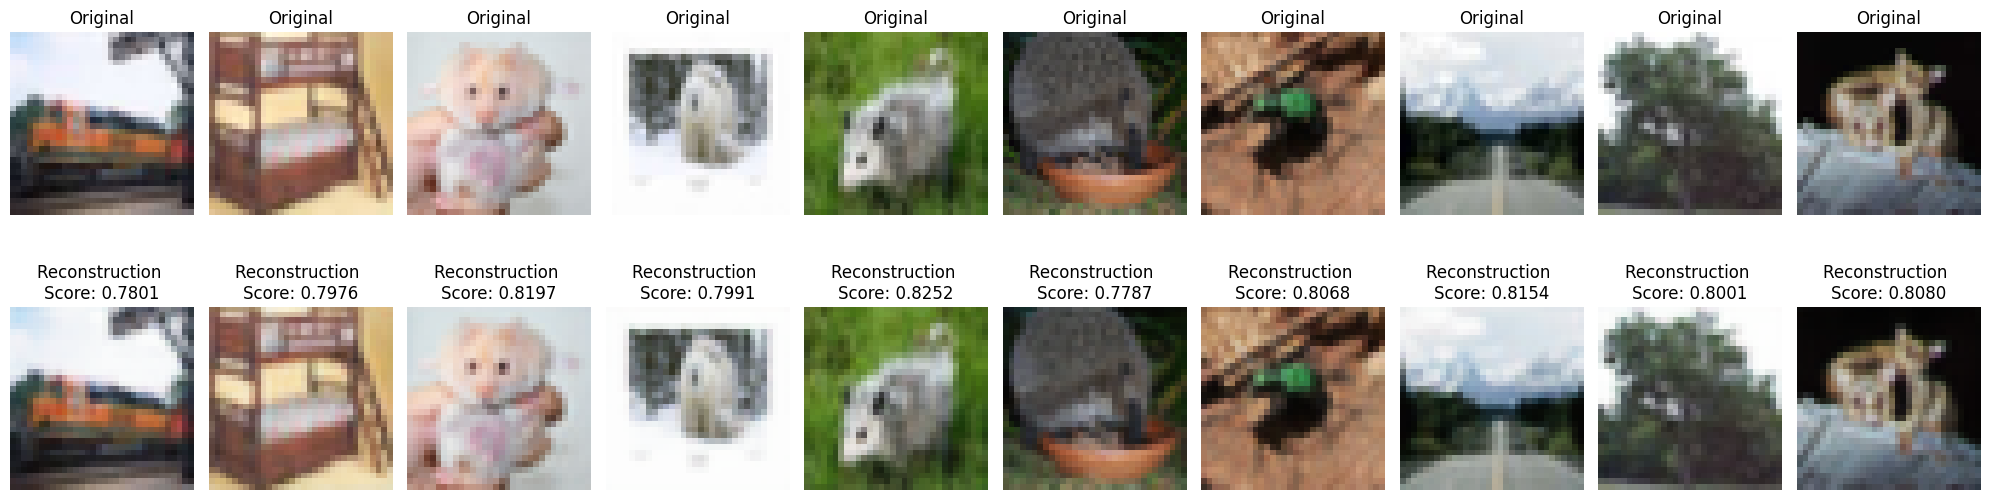

In [45]:
fig, axes = plt.subplots(2, 10, figsize=(20, 6))

for i in range(10):
    image = test_img[random.randint(0, test_img.shape[0] - 1)]
    
    file = 'og_img.png'
    plt.imsave(file, image)
    og_size = os.path.getsize(file)
    
    best, maxi = ensemble(image, og_size)
    
    axes[0, i].imshow(image)
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')

    axes[1, i].imshow(best)
    axes[1, i].set_title(f"Reconstruction \nScore: {maxi:.4f}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Comparative analysis

In [ ]:
image_scores = []
best_count = {i+1: 0 for i in range(6)}

for img_idx in range(10000):
    scores = [] 
    best_model = None
    best_score = -float('inf')

    w1,w2,w3 = 0.5,0.5,0
    
    for model_idx in range(6):
        ssim_score = ss_normalized[img_idx, model_idx]
        psnr_score = ps_normalized[img_idx, model_idx]
        compression_score = cmp_normalized[img_idx, model_idx]

        score = w1 * ssim_score + w2 * psnr_score + w3 * compression_score

        scores.append({
            'model': model_names[model_idx],
            'ssim_score': ssim_score,
            'psnr_score': psnr_score,
            'compression_score': compression_score,
            'score': score,
            'image': test_img[img_idx, model_idx]
        })

        if score > best_score:
            best_score = score
            best_model = model_idx+1

    image_scores.append(scores)
    best_count[best_model] += 1

In [ ]:
best_count

In [ ]:
count = {}
count["0.5,0.5,0"] = best_count